In [2]:
# 📌 Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 📌 Step 2: Copy zip from Drive to Colab content
!cp "/content/drive/MyDrive/Research/Dataset/Augmented/Apple/Apple_Augmented.zip" "/content/Apple_Augmented.zip"


In [4]:
# 📌 Step 3: Extract ZIP in content
import zipfile
zip_path = "/content/Apple_Augmented.zip"
extract_dir = "/content/Apple_Augmented"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [5]:
extract_path = "/content/Apple_Augmented"
train_dir = f"{extract_path}/train"
val_dir = f"{extract_path}/val"
test_dir = f"{extract_path}/test"

In [6]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size,
    label_mode='categorical', shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size,
    label_mode='categorical', shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size,
    label_mode='categorical', shuffle=False
)

class_names = train_ds.class_names  # Save for evaluation


Found 10799 files belonging to 7 classes.
Found 981 files belonging to 7 classes.
Found 982 files belonging to 7 classes.


In [7]:
# ✅ 3. Prefetch for speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [8]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = np.concatenate([y.numpy() for x, y in train_ds])
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(1.0284761904761905), 1: np.float64(1.0284761904761905), 2: np.float64(1.0284761904761905), 3: np.float64(1.0284761904761905), 4: np.float64(0.8575399031207814), 5: np.float64(1.0284761904761905), 6: np.float64(1.0284761904761905)}


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,232,839 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/50
168/338 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9999 - loss: 5.6131e-04

KeyboardInterrupt: 

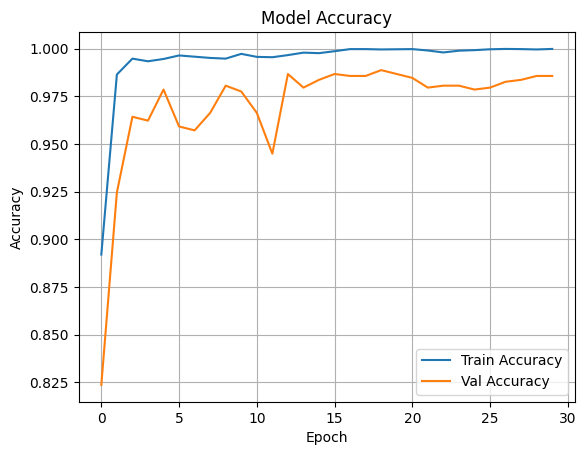

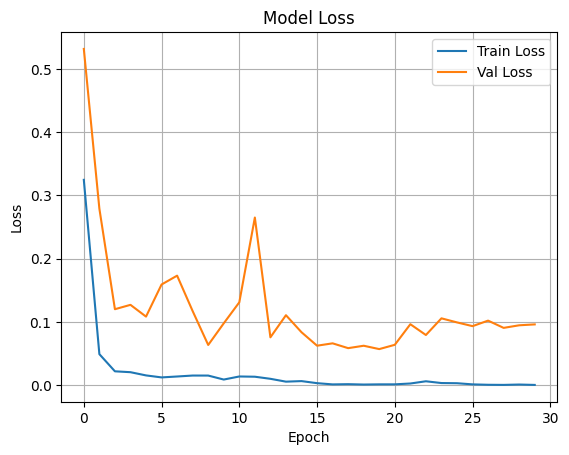

In [13]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [14]:
import numpy as np
from sklearn.metrics import classification_report

y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_true_labels = np.argmax(y_true, axis=1)

y_pred_probs = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step
Classification Report:

                              precision    recall  f1-score   support

Apple___alternaria_leaf_spot       0.97      0.88      0.92        41
           Apple___black_rot       1.00      1.00      1.00        93
          Apple___brown_spot       1.00      1.00      1.00        32
           Apple___gray_spot       0.92      0.95      0.93        60
             Apple___healthy       0.99      0.98      0.98       386
                Apple___rust       0.98      1.00      0.99       186
                Apple___scab       0.97      0.99      0.98       184

                    accuracy                           0.98       982
                   macro avg       0.98      0.97      0.97       982
                weighted avg       0.98      0.98      0.98       982



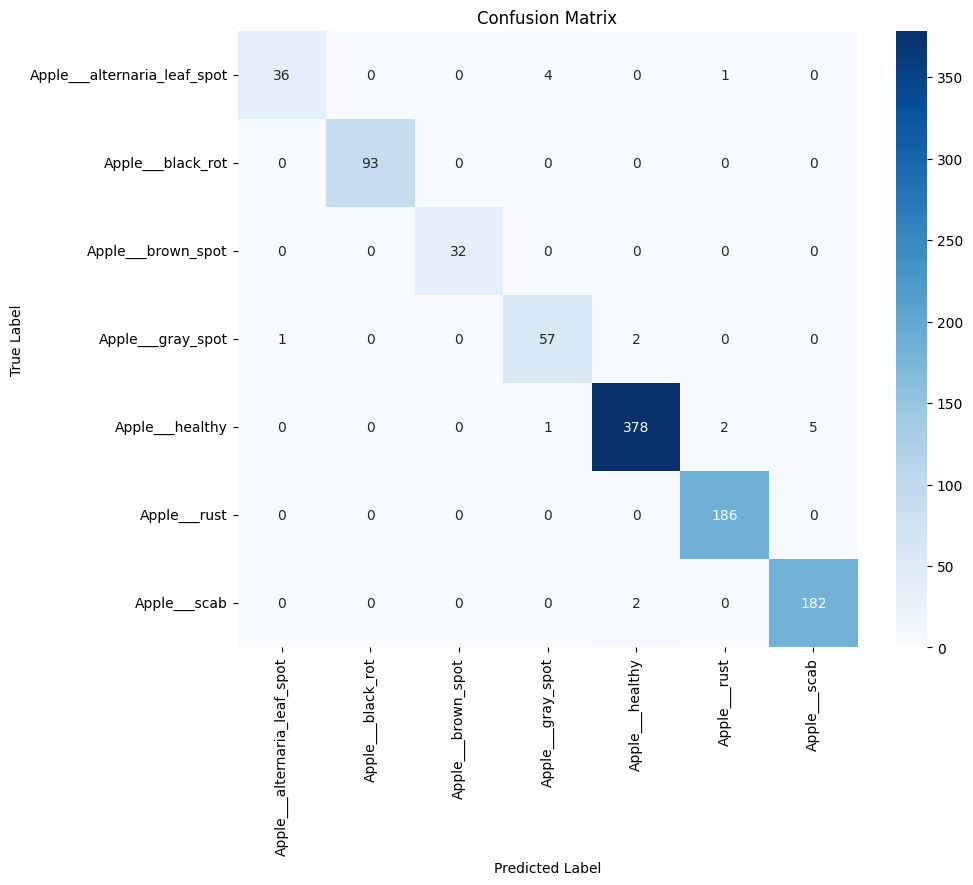

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [16]:
model.save("mobilenetv2_apple.keras")


In [17]:
import shutil
import os
# ✅ গন্তব্য ডিরেক্টরি (Drive-এ যেখানে রাখতে চাও)
drive_folder = '/content/drive/MyDrive/Research/Model'

# গন্তব্য ফোল্ডার যদি না থাকে, তৈরি করো
os.makedirs(drive_folder, exist_ok=True)

# ✅ কপি করো
shutil.copy('/content/mobilenetv2_apple.keras', os.path.join(drive_folder, 'mobilenetv2_apple.keras'))
print(f"✅ Uploaded to Google Drive: {drive_folder}")

✅ Uploaded to Google Drive: /content/drive/MyDrive/Research/Model
